In [1]:
# Initialize and Import Required Modules

In [2]:
# General Libraries
import torch
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


In [3]:
# Import the MNIST Autoencoder file
import MNIST_123  

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define arguments
args = argparse.Namespace(
    data_path="../data",
    batch_size=64,
    latent_dim=128,
    device=device
)

In [4]:
#Load the Dataset and Check It

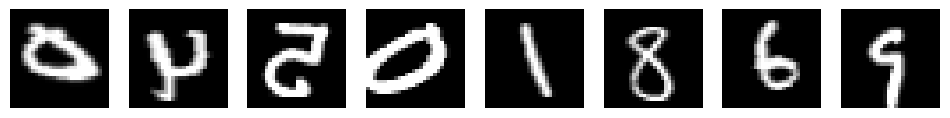

In [5]:
# Load dataset
train_loader, val_loader, test_loader = MNIST_123.load_data(args)

# Retrieve a batch of images
images, _ = next(iter(train_loader))

# Visualize some images
fig, axes = plt.subplots(1, 8, figsize=(12, 4))
for i in range(8):
    img = images[i].squeeze()
    img = img.numpy()
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
plt.show()

In [6]:
#Verify the Autoencoder Model Architecture

In [7]:
# Initialize model
model = MNIST_123.SimCLR_Encoder(args.latent_dim).to(args.device)

# Initialize standalone decoder
decoder = MNIST_123.Decoder(args.latent_dim).to(args.device)

# Print model summary
print(model)

SimCLR_Encoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=128, bias=True)
  )
)


In [10]:
#Train for One Epoch to Check Loss Computation

In [11]:
MNIST_121.train_simclr(model, train_loader, val_loader, args, epochs=20)

Epoch [1/20], Train Loss: 0.0121, Val Loss: 0.0049


Epoch [2/20], Train Loss: 0.0040, Val Loss: 0.0038


Epoch [3/20], Train Loss: 0.0030, Val Loss: 0.0029


Epoch [4/20], Train Loss: 0.0026, Val Loss: 0.0025


Epoch [5/20], Train Loss: 0.0023, Val Loss: 0.0022


Epoch [6/20], Train Loss: 0.0021, Val Loss: 0.0021


Epoch [7/20], Train Loss: 0.0020, Val Loss: 0.0020


Epoch [8/20], Train Loss: 0.0019, Val Loss: 0.0020


Epoch [9/20], Train Loss: 0.0018, Val Loss: 0.0019


Epoch [10/20], Train Loss: 0.0018, Val Loss: 0.0018


Epoch [11/20], Train Loss: 0.0017, Val Loss: 0.0017


Epoch [12/20], Train Loss: 0.0017, Val Loss: 0.0018


Epoch [13/20], Train Loss: 0.0016, Val Loss: 0.0017


Epoch [14/20], Train Loss: 0.0016, Val Loss: 0.0016


Epoch [15/20], Train Loss: 0.0016, Val Loss: 0.0016


Epoch [16/20], Train Loss: 0.0015, Val Loss: 0.0016


Epoch [17/20], Train Loss: 0.0015, Val Loss: 0.0015


Epoch [18/20], Train Loss: 0.0015, Val Loss: 0.0016


Epoch [19/20], Train Loss: 0.0015, Val Loss: 0.0015


Epoch [20/20], Train Loss: 0.0015, Val Loss: 0.0015


In [12]:
#Verify Reconstruction

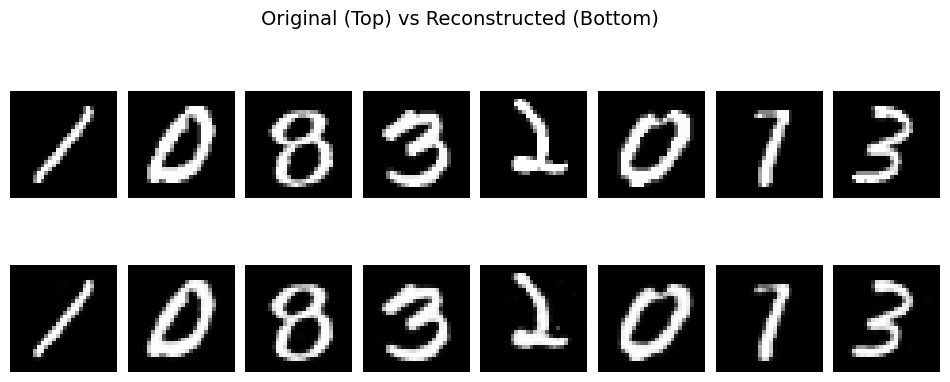

In [13]:
# Move images to the correct device
images = images.to(args.device)

# Pass images through the autoencoder to get reconstructions
with torch.no_grad():
    recon_images = model(images)
    recon_images = decoder(latent_vectors)

# Convert to CPU for visualization
images = images.cpu()
recon_images = recon_images.cpu()

# Create the figure
fig, axes = plt.subplots(2, 8, figsize=(12, 4))  # Adjusted figure size
plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Less spacing

# Set main title
fig.suptitle("Original (Top) vs Reconstructed (Bottom)", fontsize=14, y=1.05)

for i in range(8):
    # Original images
    img = images[i].numpy().transpose(1, 2, 0)  # For RGB images, reorder channels
    axes[0, i].imshow(img, cmap="gray" if img.shape[2] == 1 else None)
    axes[0, i].axis("off")

    # Reconstructed images
    recon_img = recon_images[i].numpy().transpose(1, 2, 0)  # Same for recon images
    axes[1, i].imshow(recon_img, cmap="gray" if recon_img.shape[2] == 1 else None)
    axes[1, i].axis("off")

plt.show()


In [14]:
#classifier traning

In [15]:
classifier = MNIST_121.Classifier(args.latent_dim).to(args.device)
MNIST_121.train_classifier(model, classifier, train_loader, val_loader, args, epochs=20)

Epoch [1/20], Train Loss: 0.3297, Train Acc: 90.38%, Val Acc: 95.12%


Epoch [2/20], Train Loss: 0.1787, Train Acc: 94.66%, Val Acc: 96.28%


Epoch [3/20], Train Loss: 0.1509, Train Acc: 95.50%, Val Acc: 96.78%


Epoch [4/20], Train Loss: 0.1348, Train Acc: 95.89%, Val Acc: 96.88%


Epoch [5/20], Train Loss: 0.1237, Train Acc: 96.16%, Val Acc: 96.88%


Epoch [6/20], Train Loss: 0.1143, Train Acc: 96.37%, Val Acc: 97.22%


Epoch [7/20], Train Loss: 0.1110, Train Acc: 96.42%, Val Acc: 97.06%


Epoch [8/20], Train Loss: 0.1050, Train Acc: 96.65%, Val Acc: 97.32%


Epoch [9/20], Train Loss: 0.1051, Train Acc: 96.60%, Val Acc: 97.15%


Epoch [10/20], Train Loss: 0.0979, Train Acc: 96.87%, Val Acc: 97.25%


Epoch [11/20], Train Loss: 0.0980, Train Acc: 96.88%, Val Acc: 97.15%


Epoch [12/20], Train Loss: 0.0939, Train Acc: 97.00%, Val Acc: 97.10%


Epoch [13/20], Train Loss: 0.0927, Train Acc: 96.95%, Val Acc: 97.12%


Epoch [14/20], Train Loss: 0.0903, Train Acc: 97.02%, Val Acc: 97.27%


Epoch [15/20], Train Loss: 0.0884, Train Acc: 97.16%, Val Acc: 97.19%


Epoch [16/20], Train Loss: 0.0907, Train Acc: 97.05%, Val Acc: 97.32%


Epoch [17/20], Train Loss: 0.0852, Train Acc: 97.20%, Val Acc: 97.18%


Epoch [18/20], Train Loss: 0.0855, Train Acc: 97.17%, Val Acc: 97.28%


Epoch [19/20], Train Loss: 0.0832, Train Acc: 97.25%, Val Acc: 97.23%


Epoch [20/20], Train Loss: 0.0817, Train Acc: 97.32%, Val Acc: 97.42%
